# Load packages and mount drive

## Packages

In [1]:
import IPython
from IPython.display import Audio
from scipy.io import wavfile
import librosa
from librosa import display
import os
import time as T
from datetime import datetime

import pandas as pd
import numpy as np
import math as M
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import pprint

from scipy.stats import norm

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, mean_squared_error, accuracy_score

# import utils.model_training as model_training
# import utils.data_preprocessing as data_preprocessing
import utils.utils as utils

In [6]:
X_ref = np.load('../X_mfcc_ref.npy')
X_test = np.load('datasets/processed_data/mfcc_test/X_processed.npy')

In [8]:
print(X_ref.shape)
print(X_test.shape)

print(np.mean(X_ref, axis=(0,1,2)))
print(np.mean(X_test, axis=(0,1,2)))

print(np.std(X_ref, axis=(0,1,2)))
print(np.std(X_test, axis=(0,1,2)))

(1496, 20, 201)
(1496, 20, 201)
-21.962900485300274
-21.962900485300224
107.67623175630403
107.676231756304


# Load models and parameters

## Load preprocessing and training parameters

In [2]:
MODEL_FOLDER = 'models/autoencoder_mfcc_fc_1_fc_2_ld2_ep1000/'

In [ ]:
training_parameters = utils.load_object(os.path.join(root_path, MODEL_FOLDER, 'training_parameters.pkl'))

librosa_params, input_shape, sr = model_training.load_librosa_params(training_parameters['FEATURES_LIST'])

pprint.pprint(training_parameters)
pprint.pprint(librosa_params)
print(input_shape)

{'BATCH_SIZE': 64,
 'BETA': 0.005,
 'DECAY': 0,
 'DECODER_OUTPUT': 'linear',
 'DECODER_TYPE': 'fc_2',
 'ENCODER_OUTPUT': 'linear',
 'ENCODER_TYPE': 'fc_1',
 'FEATURES_LIST': ['mfcc'],
 'IS_VARIATIONAL': False,
 'LATENT_DIM': 2,
 'LEARNING_RATE': 0.0001,
 'LOSS_TYPE': 'mse_full',
 'NORMALIZE_TYPE': 'avg_std_fband_split',
 'N_EPOCHS': 1000,
 'SAVE_TO': 'models/autoencoder_mfcc_fc_1_fc_2_ld2_ep1000/',
 'USE_CUSTOM_LOSS': True}
{'hop_length': 40,
 'n_fft': 128,
 'n_mels': 64,
 'n_mfcc': 20,
 'sigma_noise': 0,
 'win_length': 120,
 'window': 'hann'}
(20, 201)


## Load autoencoder

In [ ]:
custom_objects = {
    'CustomVariationalLayer': utils.CustomVariationalLayer(beta=training_parameters['BETA']),
    'leaky_relu': tf.nn.leaky_relu
}

#load autoencoder
loaded_autoencoder = utils.load_model(os.path.join(root_path, MODEL_FOLDER, 'autoencoder'), custom_objects)

#load encoder
loaded_encoder = utils.load_model(os.path.join(root_path, MODEL_FOLDER, 'encoder'), custom_objects)

#load decoder
loaded_decoder = utils.load_model(os.path.join(root_path, MODEL_FOLDER, 'decoder'), custom_objects)

Model loaded from /content/drive/My Drive/workspace/internship_virgile_aniti/autoencoder_spoken_mnist/models/autoencoder_mfcc_fc_1_fc_2_ld2_ep1000/autoencoder/ with:
 - model's name: full_auto_encoder 
 - input shape: (None, 4020) 
 - output shape: (None, 4020)
 - last modified: 2020-11-27 07:54:33
Model loaded from /content/drive/My Drive/workspace/internship_virgile_aniti/autoencoder_spoken_mnist/models/autoencoder_mfcc_fc_1_fc_2_ld2_ep1000/encoder/ with:
 - model's name: encoder_fc_1 
 - input shape: (None, 4020) 
 - output shape: (None, 2)
 - last modified: 2020-11-27 07:54:34
Model loaded from /content/drive/My Drive/workspace/internship_virgile_aniti/autoencoder_spoken_mnist/models/autoencoder_mfcc_fc_1_fc_2_ld2_ep1000/decoder/ with:
 - model's name: decoder_fc_2 
 - input shape: (None, 2) 
 - output shape: (None, 4020)
 - last modified: 2020-11-27 07:54:34


In [ ]:
count_trainable = np.sum([loaded_autoencoder.trainable_weights[i].numpy().size for i in range(len(loaded_autoencoder.trainable_weights))])
count_non_trainable = np.sum([loaded_autoencoder.non_trainable_weights[i].numpy().size for i in range(len(loaded_autoencoder.non_trainable_weights))])
print(count_trainable)
print(count_non_trainable)

179483752
30912


In [ ]:
# training_parameters['FEATURES_LIST'] = ['wav']
# training_parameters['NORMALIZE_TYPE'] = None
# training_parameters['LATENT_DIM'] = 100

# pprint.pprint(training_parameters)

## Load CNN classifier

In [ ]:
if training_parameters['FEATURES_LIST'][0] != 'wav':

    loaded_classifier = utils.load_model(os.path.join(root_path, 'models', f"classifier_{training_parameters['FEATURES_LIST'][0]}"), custom_objects)

# Load training data and feed the trained model

In [ ]:
X, dimensions, y_digits, y_speakers, train_index = model_training.load_data(training_parameters['FEATURES_LIST'])
X_train = X[train_index]
y_digits_train = y_digits[train_index]
y_speakers_train = y_speakers[train_index]

X_train_norm, norm_params = model_training.normalize(X_train, training_parameters['NORMALIZE_TYPE'], input_shape)
X_train_from_normalized = model_training.inv_normalize(X_train_norm, training_parameters['NORMALIZE_TYPE'], norm_params, input_shape)

X_train_encoded = loaded_encoder.predict(X_train_norm, batch_size=X_train_norm.shape[0]//10)

X_train_decoded_norm = loaded_decoder.predict(X_train_encoded[:, :training_parameters['LATENT_DIM']], batch_size=X_train_encoded.shape[0]//10)

X_train_decoded = model_training.inv_normalize(X_train_decoded_norm, training_parameters['NORMALIZE_TYPE'], norm_params, input_shape)

# y_pred_input_train = np.argmax(loaded_classifier.predict(X_train.reshape(X_train.shape[0], *input_shape, 1), batch_size=X_train.shape[0]//10), axis=1)
# y_pred_normalized = np.argmax(loaded_classifier.predict(X_train_from_normalized.reshape(X_train_from_normalized.shape[0], *input_shape, 1), batch_size=X_train_from_normalized.shape[0]//10), axis=1)
# y_pred_decoded_train = np.argmax(loaded_classifier.predict(X_train_decoded.reshape(X_train.shape[0], *input_shape, 1), batch_size=X_train.shape[0]//10), axis=1)

# Latent training distribution (if latent_dim <= 2)

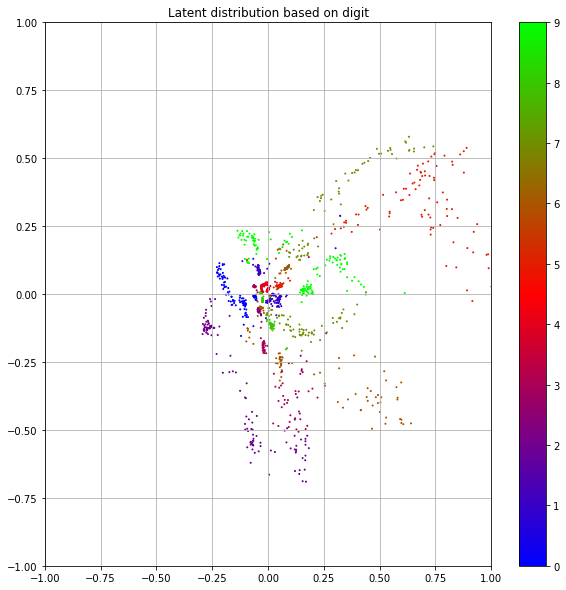

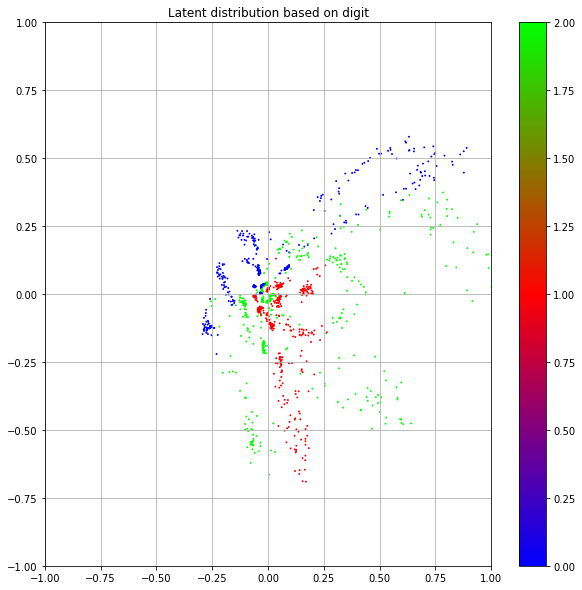

In [ ]:
# training set

# Rescale data
# latent_avg = np.mean(X_train_encoded, axis=0)
# X_rescaled = (X_train_encoded - latent_avg)
# latent_max_deviation = np.max(np.abs(X_rescaled), axis=0)
# X_rescaled = X_rescaled / latent_max_deviation
# OR
alpha = .05
q0, q1, q2 = np.quantile(X_train_encoded, alpha/2, axis=0),  np.quantile(X_train_encoded, 1/2, axis=0), np.quantile(X_train_encoded, 1-alpha/2, axis=0)
X_rescaled = (X_train_encoded - q1) / (q2 -q0)
# OR
# X_rescaled = X_train_encoded

y_digits_train = np.load(os.path.join(root_path, 'datasets', 'y_digits.npy'))[train_index]
y_speakers_train = np.load(os.path.join(root_path, 'datasets', 'y_speakers.npy'))[train_index]

x_min, x_max = -1, 1
y_min, y_max = -1, 1

plt.figure(figsize=(10, 10))

# plt.subplot(2, 1, 1)
plt.scatter(X_rescaled[:, 0], X_rescaled[:, 1], c=y_digits_train, cmap='brg', s=1)
# a1, b1 = 1, .1
# a2, b2 = -2.5, -.25
# x = np.linspace(-.3, -.1)
# plt.plot(x, a1*x+b1, linewidth=2, linestyle='dashed', color='grey')
# plt.plot(x, a2*x+b2, linewidth=2, linestyle='dashed', color='grey')
plt.colorbar()
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.title('Latent distribution based on digit')
plt.grid()

filename = f"latent_distrib_digits_{training_parameters['FEATURES_LIST'][0]}_{training_parameters['ENCODER_TYPE']}_{training_parameters['DECODER_TYPE']}.png"
plt.savefig(os.path.join(root_path, 'results', filename))
plt.show()

plt.figure(figsize=(10, 10))
plt.scatter(X_rescaled[:, 0], X_rescaled[:, 1], c=y_speakers_train, cmap='brg', s=.8)
# plt.plot(np.linspace(-15, 15, 1000), 1.5 + .5 * np.linspace(-15, 15, 1000), linestyle='dashed', color='grey')
plt.colorbar()
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.title('Latent distribution based on digit')
plt.grid()

filename = f"latent_distrib_speakers_{training_parameters['FEATURES_LIST'][0]}_{training_parameters['ENCODER_TYPE']}_{training_parameters['DECODER_TYPE']}.png"
plt.savefig(os.path.join(root_path, 'results', filename))
plt.show()

In [ ]:
# plot_model(loaded_encoder, to_file=os.path.join(root_path, 'results', 'encoder_scheme.png'), show_shapes=True, expand_nested=True)
# plot_model(loaded_decoder, to_file=os.path.join(root_path, 'results', 'decoder_scheme.png'), show_shapes=True, expand_nested=True)

In [ ]:
anormal_index = (X_rescaled[:,1] < 0)
normal_index = (X_rescaled[:,1] >= 0)

X_train_anormal = X_train[anormal_index]
X_train_normal = X_train[normal_index]

y_digits_train_anormal = y_digits_train[anormal_index]
y_digits_train_normal = y_digits_train[normal_index]

plt.figure()
plt.hist(y_digits_train_anormal, bins=np.arange(0, 10, 1))
plt.show()

plt.figure()
plt.hist(y_digits_train_normal, bins=np.arange(0, 10, 1))
plt.show()

plt.figure()
plt.hist(y_speakers_train_anormal, bins=3)
plt.show()

plt.figure()
plt.hist(y_speakers_train_normal, bins=3)
plt.show()

y_speakers_train_anormal = y_speakers_train[anormal_index]
y_speakers_train_normal = y_speakers_train[normal_index]

X_wav_train = np.load(os.path.join(root_path, 'datasets', 'X_wav.npy'))[train_index]

X_wav_modified = np.zeros(X_wav_train.shape)

print('=========')
print('ANORMAL:')
print('=========')

for i in range(27, 40):
    
    x = X_train_anormal[i].reshape(20, 201)

    vmin = np.min(x, axis=(0,1))
    vmax = np.max(x, axis=(0,1))
    cmap = plt.get_cmap('viridis')

    plt.figure(figsize=(12, 4))
    plt.pcolor(x, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.xlabel('Time')
    plt.title('Normalized input')
    plt.colorbar()
    # plt.savefig(os.path.join(root_path, 'results', 'normalized_input.png'))
    plt.show()

print('=========')
print('NORMAL:')
print('=========')

for i in range(27, 40):
    
    x = X_train_normal[i].reshape(20, 201)

    vmin = np.min(x, axis=(0,1))
    vmax = np.max(x, axis=(0,1))
    cmap = plt.get_cmap('viridis')

    plt.figure(figsize=(12, 4))
    plt.pcolor(x, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.xlabel('Time')
    plt.title('Normalized input')
    plt.colorbar()
    # plt.savefig(os.path.join(root_path, 'results', 'normalized_input.png'))
    plt.show()

all_ends, anormal_ends, normal_ends = [], [], []
for i in range(X_wav_train.shape[0]):
    end = np.where(X_wav_train[i]==0)[0][2]
    all_ends += [end]
    if anormal_index[i]==1:
        anormal_ends += [end]
    if normal_index[i]==1:
        normal_ends += [end]

plt.figure()
plt.hist(all_ends, bins=100)
plt.show()

plt.figure()
plt.hist(anormal_ends, bins=100)
plt.show()

plt.figure()
plt.hist(normal_ends, bins=100)
plt.show()

In [ ]:
i=333
plt.figure()
plt.plot(X_wav_train[i])
plt.show()
Audio(X_wav_train[i], rate=8000)

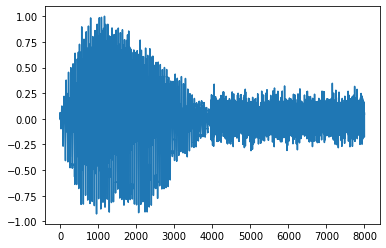

In [ ]:
plt.figure()
plt.plot(X_wav_modified[i])
plt.show()
Audio(X_wav_modified[i], rate=8000)

# Manifold plot

In [ ]:
n=81  # figure with nxn digits
digit_size = 28
k = 5 # k main digits considered
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Compute step_x, step_y
step_x = (x_max-x_min)/(n-1)
step_y = (y_max-y_min)/(n-1)

# Initialize global figure
figure = np.zeros((digit_size * n, digit_size * n, 3))

# Construct grid of latent variable values
grid_x = np.linspace(x_min, x_max, n)
grid_y = np.linspace(y_max, y_min, n)

# Compute global norm params to reconstruct MFCC one-by-one
global_norm_params = {}
for key in norm_params:
    global_norm_params[key] = np.mean(norm_params[key], axis=0)

# Load 28x28 drawn digits
drawn_digits = np.zeros((10, 28, 28, 1))
for i in range(10):
    drawn_digits[i] = np.load(os.path.join(root_path, 'digits_npy_28_28', f'example_{i}.npy')).reshape(28, 28, 1)

# decode for each square in the grid
for i, xi in enumerate(grid_x):
    for j, yj in enumerate(grid_y):
        x, y = xi+step_x/2, yj-step_y/2
        z_sample = np.array([[x, y]])
        z_unscaled = q1 + z_sample*(q2-q0)
        decoded_mfcc_norm = loaded_decoder.predict(z_unscaled, batch_size=1)
        decoded_mfcc = model_training.inv_normalize(
            decoded_mfcc_norm, 
            normalize_type=training_parameters['NORMALIZE_TYPE'], 
            norm_params=global_norm_params,
            input_shape=input_shape
        )
        
        probas = loaded_classifier.predict(decoded_mfcc.reshape(1, *input_shape, 1), batch_size=1)

        weighted_digits = probas.reshape(10, 1, 1, 1)*drawn_digits
        ordered_digits_desc = np.flip(np.argsort(probas)).reshape(-1)
        digit = np.sum(probas.reshape(-1)[ordered_digits_desc[:k]]) * np.sum(weighted_digits[ordered_digits_desc[:k]], axis=0).reshape(28, 28, 1)
        # digit = np.ones(digit.shape) - digit
        training_traceback = np.mean((np.abs(X_rescaled[:, 0] - x) < step_x/2) & (np.abs(X_rescaled[:, 1] - y) < step_y/2))
        background = (digit<1e-5)

        r = 1 - np.max(probas) * digit
        g = 1 - np.max(probas) * digit
        b = 1 - np.max(probas) * digit

        g[background] = g[background] - min(100 * training_traceback, 1)
        b[background] = b[background] - min(100 * training_traceback, 1)

        subsquare = np.concatenate((r, g, b), axis=2)
        
        figure[j * digit_size: (j + 1) * digit_size,
               i * digit_size: (i + 1) * digit_size, :] = subsquare

if np.min(figure, axis=(0,1,2)) > -1e-3:
    figure[figure<0] = 0

plt.figure(figsize=(15, 15))
plt.imshow(figure, extent=[x_min, x_max, y_min, y_max])
filename = f"manifold_plot_variational.png"
plt.savefig(os.path.join(root_path, 'results', filename))
plt.show()

NameError: ignored

# Reconstruction on training set

## Wave reconstruction

### Visualization of an example

In [ ]:
i = 333

dim = input_shape[0]*input_shape[1]

digit = y_digits_train[i]
speaker = y_speakers_train[i]

input = X_train[i, :dim].reshape(input_shape)
input_from_normalized = X_train_from_normalized[i, :dim].reshape(input_shape)
decoded = X_train_decoded[i, :dim].reshape(input_shape)

x = X_train_norm[i, :dim].reshape(input_shape)
y = X_train_decoded_norm[i, :dim].reshape(input_shape)

# print(f'digit: {digit}, latent_code: {X_train_encoded[i]} (rescaled: {X_rescaled[i]}).')

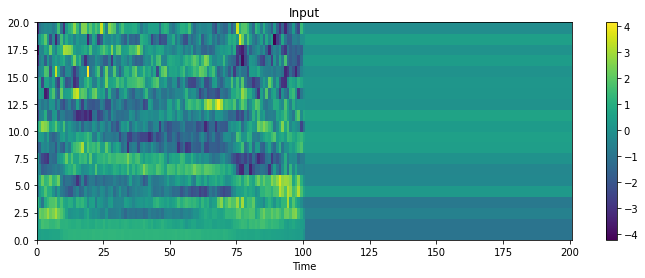

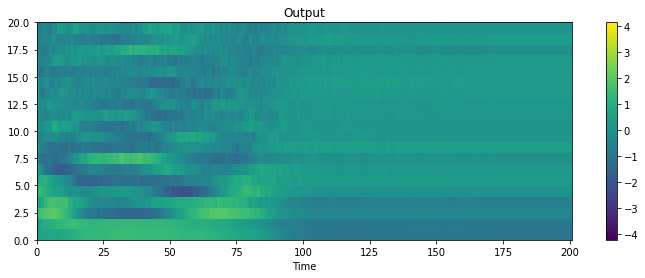

In [ ]:
vmin = min(np.min(x, axis=(0,1)), np.min(y, axis=(0,1)))
vmax = max(np.max(x, axis=(0,1)), np.max(y, axis=(0,1)))
cmap = plt.get_cmap('viridis')

plt.figure(figsize=(12, 4))
plt.pcolor(x, cmap=cmap, vmin=vmin, vmax=vmax)
plt.xlabel('Time')
plt.title('Input')
plt.colorbar()
plt.savefig(os.path.join(root_path, 'results', 'normalized_input.png'))
plt.show()

plt.figure(figsize=(12, 4))
plt.pcolor(y, cmap=cmap, vmin=vmin, vmax=vmax)
plt.xlabel('Time')
plt.title('Output')
plt.colorbar()
plt.savefig(os.path.join(root_path, 'results', 'normalized_output.png'))
plt.show()

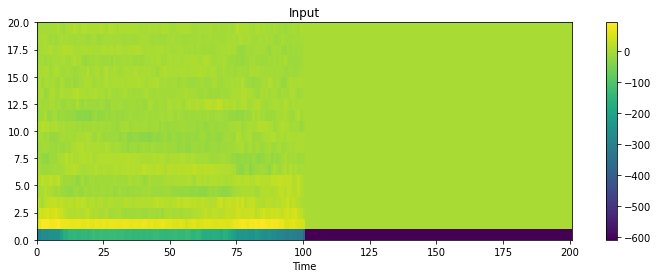

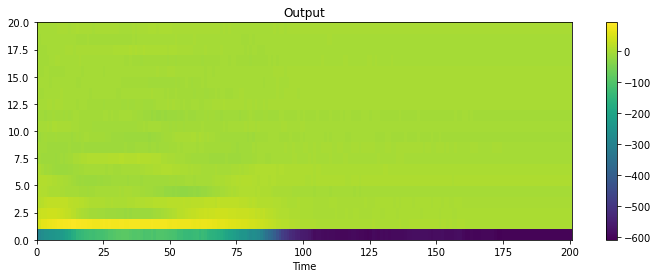

In [ ]:
vmin = min(np.min(input, axis=(0,1)), np.min(decoded, axis=(0,1)))
vmax = max(np.max(input, axis=(0,1)), np.max(decoded, axis=(0,1)))
cmap = plt.get_cmap('viridis')

plt.figure(figsize=(12, 4))
plt.pcolor(input, cmap=cmap, vmin=vmin, vmax=vmax)
plt.xlabel('Time')
plt.title('Input')
plt.colorbar()
plt.savefig(os.path.join(root_path, 'results', 'input.png'))
plt.show()

plt.figure(figsize=(12, 4))
plt.pcolor(decoded, cmap=cmap, vmin=vmin, vmax=vmax)
plt.xlabel('Time')
plt.title('Output')
plt.colorbar()
plt.savefig(os.path.join(root_path, 'results', 'decoded.png'))
plt.show()

In [ ]:
if training_parameters['FEATURES_LIST'] == ['mfcc']:

    wav_from_input = librosa.feature.inverse.mfcc_to_audio(
        input, 
        n_mels=librosa_params['n_mels'], 
        dct_type=2, 
        norm="ortho", 
        ref=1.0, 
        lifter=0,
        sr=sr,
        n_fft=librosa_params['n_fft'],
        hop_length=librosa_params['hop_length'],
        win_length=librosa_params['win_length'],
        window='hann'
    )

    wav_from_input_from_normalized = librosa.feature.inverse.mfcc_to_audio(
        input_from_normalized, 
        n_mels=librosa_params['n_mels'], 
        dct_type=2, 
        norm="ortho", 
        ref=1.0, 
        lifter=0,
        sr=sr,
        n_fft=librosa_params['n_fft'],
        hop_length=librosa_params['hop_length'],
        win_length=librosa_params['win_length'],
        window='hann'
    )

    wav_from_decoded = librosa.feature.inverse.mfcc_to_audio(
        decoded, 
        n_mels=librosa_params['n_mels'], 
        dct_type=2, 
        norm="ortho", 
        ref=1.0, 
        lifter=0,
        sr=sr,
        n_fft=librosa_params['n_fft'],
        hop_length=librosa_params['hop_length'],
        win_length=librosa_params['win_length'],
        window='hann'
    )

elif training_parameters['FEATURES_LIST'] == ['mel']:

    if librosa_params['mel_in_db']:
        input = librosa.core.db_to_power(input)
        input_from_normalized = librosa.core.db_to_power(input_from_normalized)
        decoded = librosa.core.db_to_power(decoded)

    wav_from_input = librosa.feature.inverse.mel_to_audio(
        input,
        sr=sr,
        n_fft=librosa_params['n_fft'],
        hop_length=librosa_params['hop_length'],
        win_length=librosa_params['win_length'],
        window='hann'
    )

    wav_from_input_from_normalized = librosa.feature.inverse.mel_to_audio(
        input_from_normalized,
        sr=sr,
        n_fft=librosa_params['n_fft'],
        hop_length=librosa_params['hop_length'],
        win_length=librosa_params['win_length'],
        window='hann'
    )

    wav_from_decoded = librosa.feature.inverse.mel_to_audio(
        decoded,
        sr=sr,
        n_fft=librosa_params['n_fft'],
        hop_length=librosa_params['hop_length'],
        win_length=librosa_params['win_length'],
        window='hann'
    )   

wav_ref = np.load(os.path.join(root_path, 'datasets', 'X_wav.npy'))[train_index][i]

# predicted_digit_ref = np.argmax(loaded_classifier.predict(input.reshape(1, *input.shape, 1), batch_size=1))
# predicted_digit_normalized = np.argmax(loaded_classifier.predict(input_from_normalized.reshape(1, *input.shape, 1), batch_size=1))
# predicted_digit_decoded = np.argmax(loaded_classifier.predict(decoded.reshape(1, *decoded.shape, 1), batch_size=1))

## Presentation (1)

Initial wave
Digit: 9


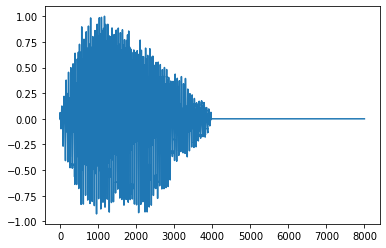

In [ ]:
print('Initial wave')
print('======================================')
print('Digit: {}'.format(digit))
# print('Predicted digit: {}'.format(predicted_digit_ref))
plt.plot(wav_ref)
plt.show()

Audio(wav_ref, rate=sr)

Wave from input (librosa+librosa_back)


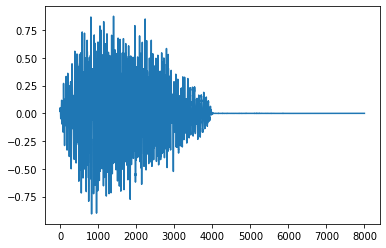

In [ ]:
print('Wave from input (librosa+librosa_back)')
print('======================================')

plt.plot(wav_from_input)
plt.show()

Audio(wav_from_input, rate=sr)

Wave from decoded (librosa+normalization+autoencoder+denormalization+librosa_back)


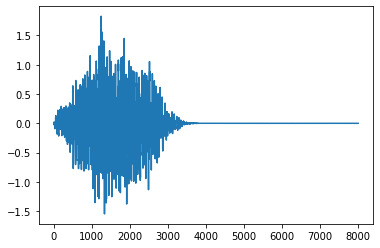

In [ ]:
print('Wave from decoded (librosa+normalization+autoencoder+denormalization+librosa_back)')
# print('Predicted digit: {}'.format(predicted_digit_decoded))

plt.plot(wav_from_decoded)
plt.show()

Audio(wav_from_decoded, rate=sr)

### Global classification reports

In [ ]:
print('==================================================\n')
print('Predictions on the training set.\n')
print('==================================================\n')
print(confusion_matrix(y_digits_train, y_pred_input_train))
print('==================================================\n')
print('Predictions on the training set (after normalization).\n')
print('==================================================\n')
print(confusion_matrix(y_digits_train, y_pred_normalized))
print('==================================================\n')
print('Predictions on the decoded set.\n')
print('==================================================\n')
print(confusion_matrix(y_digits_train, y_pred_decoded_train))
print('==================================================\n')
print(f'Accuracy on the decoded set: {round(100*accuracy_score(y_digits_train, y_pred_decoded_train), 1)}%')

# filename = f'classification_report.txt'
# with open(os.path.join(root_path, 'results', filename), "w") as f:
#     f.write('=======================================\n')
#     f.write('Predictions on the training set. \n')
#     f.write('=======================================\n')
#     f.write(str(confusion_matrix(y_digits_train, y_pred_input_train)))
#     f.write('\n=======================================\n')
#     f.write('Predictions on the decoded set. \n')
#     f.write('=======================================\n')
#     f.write(str(confusion_matrix(y_digits_train, y_pred_decoded_train)))
#     f.write('\n=======================================\n')
#     f.write(f'Accuracy on the decoded set: {round(100*accuracy_score(y_digits_train, y_pred_decoded_train), 1)}%')


Predictions on the training set.


[[141   0   0   0   0   0   0   0   0   0]
 [  0 139   0   0   0   0   0   0   0   0]
 [  0   0 142   0   0   0   0   0   0   0]
 [  0   0   0 143   0   0   0   0   0   0]
 [  0   0   0   0 135   0   0   0   0   0]
 [  0   0   0   0   0 139   0   0   0   0]
 [  0   0   0   1   0   0 137   0   0   0]
 [  0   0   0   0   0   0   1 135   0   0]
 [  0   0   0   0   0   0   0   0 145   0]
 [  0   0   0   0   0   0   0   0   0 138]]

Predictions on the training set (after normalization).


[[141   0   0   0   0   0   0   0   0   0]
 [  0 139   0   0   0   0   0   0   0   0]
 [  0   0 142   0   0   0   0   0   0   0]
 [  0   0   0 143   0   0   0   0   0   0]
 [  0   0   0   0 135   0   0   0   0   0]
 [  0   0   0   0   0 139   0   0   0   0]
 [  0   0   0   1   0   0 137   0   0   0]
 [  0   0   0   0   0   0   1 135   0   0]
 [  0   0   0   0   0   0   0   0 145   0]
 [  0   0   0   0   0   0   0   0   0 138]]

Predictions on the decoded set.


[[140   0

0: [ 177 1069  284  569  254  144  493 1079  886]
0: [1146  882  593 1170  645  178  530  627  436]
0: [ 133  681  454  599 1248  192  446  889  657]
1: [1335 1310  813  556 1114  367  649  615 1205]
1: [ 210  706 1213   93  582  693 1380 1057  253]
1: [ 875  336  776  688  337 1102  794 1202    2]
2: [1126 1313   79    5  326   87  557 1227  538]
2: [ 218   64  498   36 1265  104 1026  762  275]
2: [ 910  387  917  735 1196  230  827  233  969]
3: [ 724  107  873  864 1222  564  631  310  784]
3: [  8 695 427 588 216 862 250 545 296]
3: [ 467  456  186 1260  787 1145  814  892  638]
4: [1062 1053  238 1162  316  844  928 1372  491]
4: [ 684  952  116 1001  200 1129  411  845 1246]
4: [1368 1278 1274  611  286 1139 1031  506  223]
5: [1121  303  759 1327 1149  381 1369  774  547]
5: [ 105  971  637  865 1305  312 1173  610  713]
5: [421 838 846 532 740 996 654 225 121]
6: [1318 1151  136  632  726 1321 1214  341 1350]
6: [ 810  609  151   50  319 1221   26  708 1354]
6: [ 860 1017  294

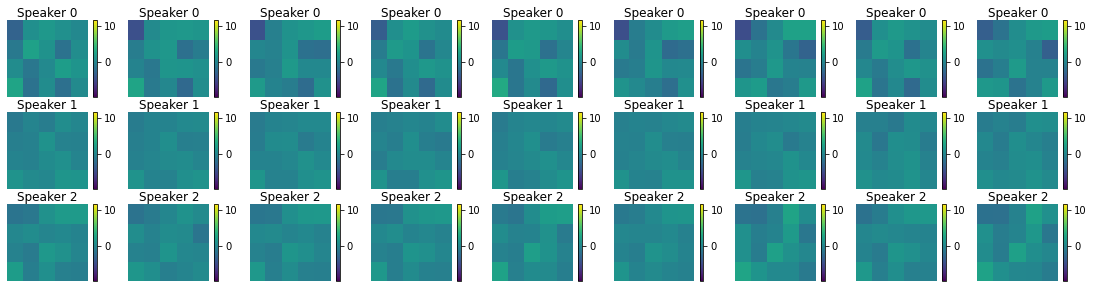

1:


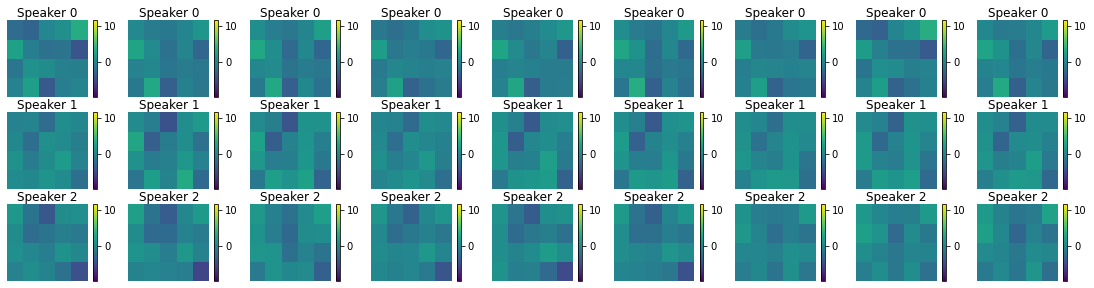

2:


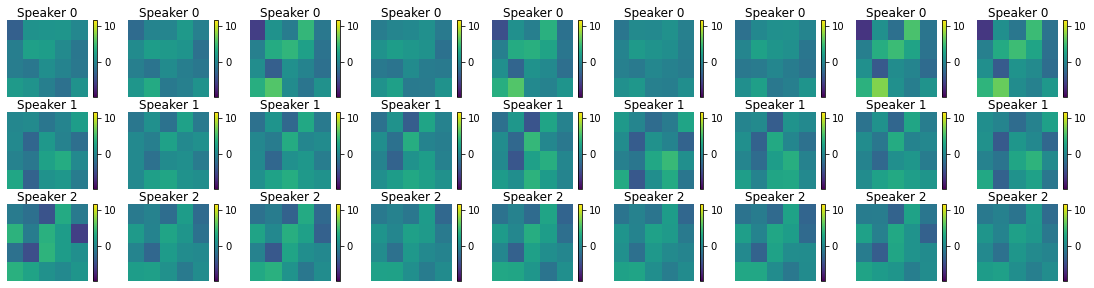

3:


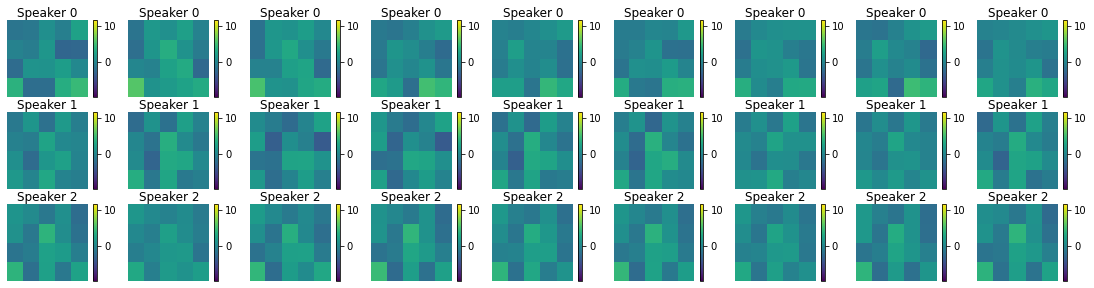

4:


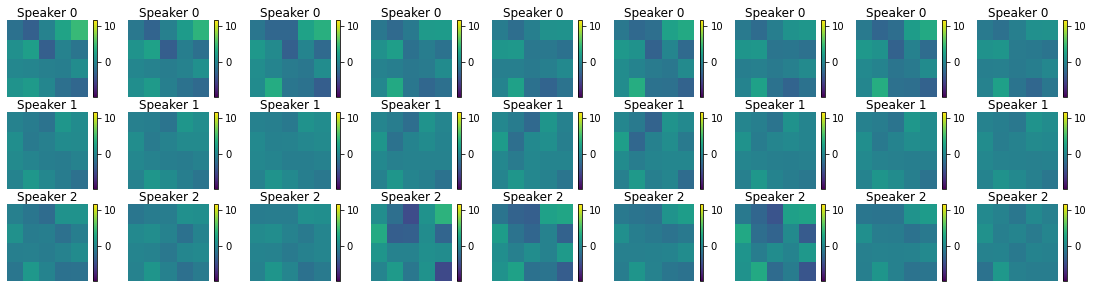

5:


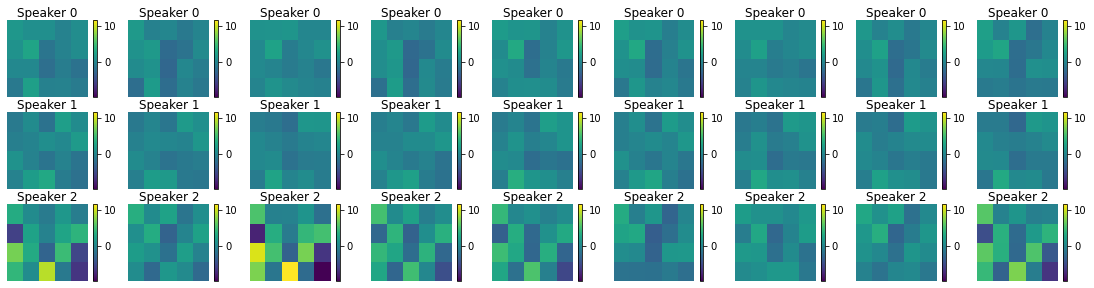

6:


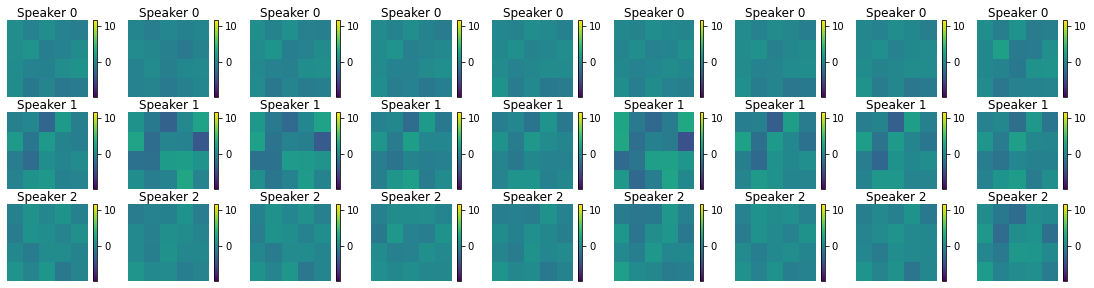

7:


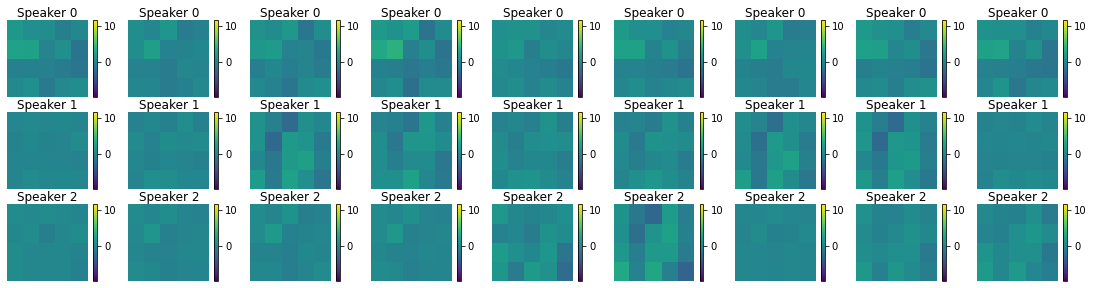

8:


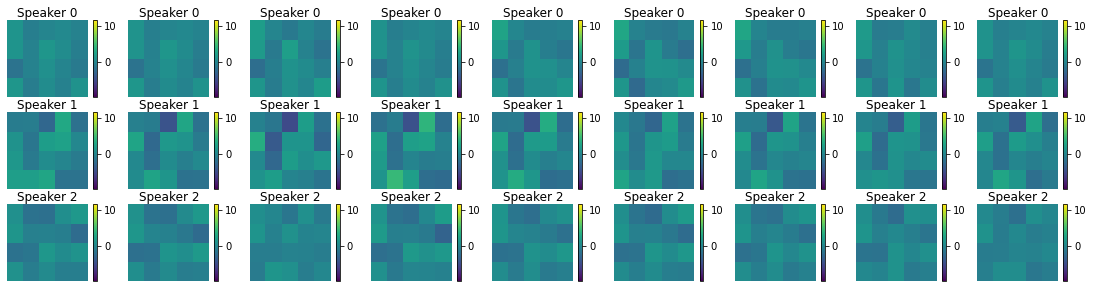

9:


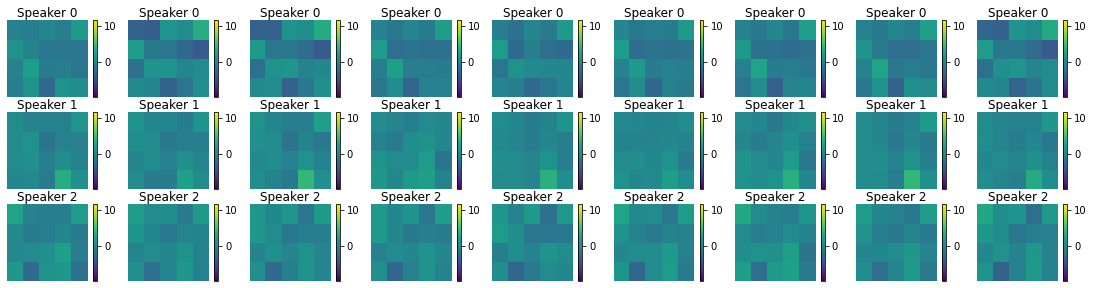

In [ ]:
np.random.seed(69)

X_encoded_digits = np.zeros((10, 3, 9, 20))

for digit in range(10):
    
    for speaker in range(3):

        digit_pos = np.where(((y_digits_train == digit)&(y_speakers_train == speaker)).reshape(-1))[0]
        random_pos = np.random.choice(digit_pos, size=9, replace=False)

        X_encoded_digits[digit, speaker] = X_train_encoded[random_pos, :training_parameters['LATENT_DIM']]
    
        print(f'{digit}: {random_pos}')

X_encoded_digits = X_encoded_digits.reshape(10, 27, 20)

vmin = np.min(X_encoded_digits, axis=(0,1,2))
vmax = np.max(X_encoded_digits, axis=(0,1,2))
cmap = plt.get_cmap('viridis')

for digit in range(10):

    print(f'{digit}:')
    
    plt.figure(figsize=(19.2, 4.8))
    for i in range(27):
        
        plt.subplot(3,9,1+i)
        plt.pcolor(X_encoded_digits[digit][i].reshape(4, 5), cmap=cmap, vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title(f'Speaker {i//9}', pad=0)
        plt.axis('off')
    
    # plt.savefig(os.path.join(root_path, 'results', f'encoded_examples_{digit}.png'))
    plt.show()
    print('=====================================')

In [ ]:
X_wav_train = np.load(os.path.join(root_path, 'datasets', 'X_wav.npy'))[train_index]

Audio(X_wav_train[1276], rate=8000)

In [ ]:
y_speakers_train[1276]

2

0: [ 828  266 1140  689  323  433  867  595  455]


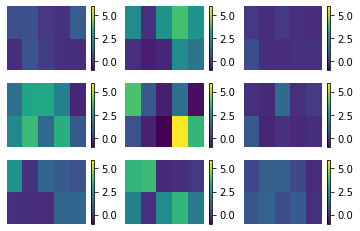

1: [1304  545 1395 1129 1207 1117 1241 1120 1226]


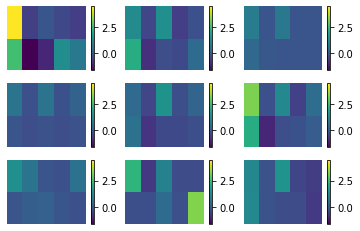

2: [ 990 1148  740  454  846  176  446  775 1285]


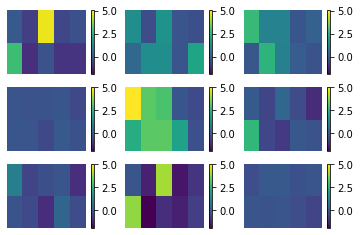

In [ ]:
for digit in range(3):

    digit_pos = np.where((y_speakers_train == digit).reshape(-1))[0]
    random_pos = np.random.choice(digit_pos, size=9, replace=False)

    X_encoded_digit = X_train_encoded[random_pos]

    vmin = np.min(X_encoded_digit, axis=(0,1))
    vmax = np.max(X_encoded_digit, axis=(0,1))
    cmap = plt.get_cmap('viridis')


    print(f'{digit}: {random_pos}')
    
    plt.figure()
    for i, pos in enumerate(list(random_pos)):
        
        plt.subplot(331+i)
        plt.pcolor(X_train_encoded[pos].reshape(2, 5), cmap=cmap, vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.axis('off')
    
    # plt.savefig(os.path.join(root_path, 'results', f'encoded_examples_{digit}.png'))
    plt.show()
    print('=====================================')

# Reconstruction (for wave autoencoder)

In [ ]:
i = 267

input = X_train[i]
output = X_train_decoded[i]

digit = y_digits_train[i]

Initial wave
Digit: 5


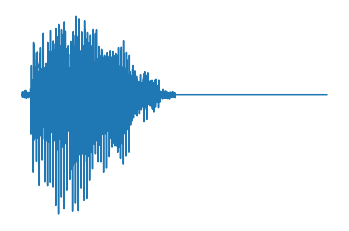

In [ ]:
print('Initial wave')
print('======================================')
print('Digit: {}'.format(digit))
plt.plot(input)
plt.axis('off')
plt.savefig(os.path.join(root_path, 'results', 'input_1.png'))

plt.show()


Audio(input, rate=sr)

Output wave


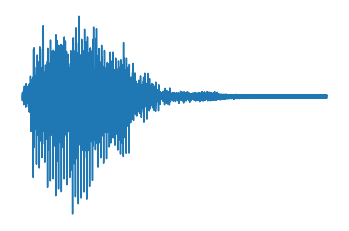

In [ ]:
print('Output wave')
print('======================================')
plt.plot(output)
plt.axis('off')
plt.show()

Audio(output, rate=sr)

0: [ 177 1069  284  569  254  144  493 1079  886]
0: [1146  882  593 1170  645  178  530  627  436]
0: [ 133  681  454  599 1248  192  446  889  657]
1: [1335 1310  813  556 1114  367  649  615 1205]
1: [ 210  706 1213   93  582  693 1380 1057  253]
1: [ 875  336  776  688  337 1102  794 1202    2]
2: [1126 1313   79    5  326   87  557 1227  538]
2: [ 218   64  498   36 1265  104 1026  762  275]
2: [ 910  387  917  735 1196  230  827  233  969]
3: [ 724  107  873  864 1222  564  631  310  784]
3: [  8 695 427 588 216 862 250 545 296]
3: [ 467  456  186 1260  787 1145  814  892  638]
4: [1062 1053  238 1162  316  844  928 1372  491]
4: [ 684  952  116 1001  200 1129  411  845 1246]
4: [1368 1278 1274  611  286 1139 1031  506  223]
5: [1121  303  759 1327 1149  381 1369  774  547]
5: [ 105  971  637  865 1305  312 1173  610  713]
5: [421 838 846 532 740 996 654 225 121]
6: [1318 1151  136  632  726 1321 1214  341 1350]
6: [ 810  609  151   50  319 1221   26  708 1354]
6: [ 860 1017  294

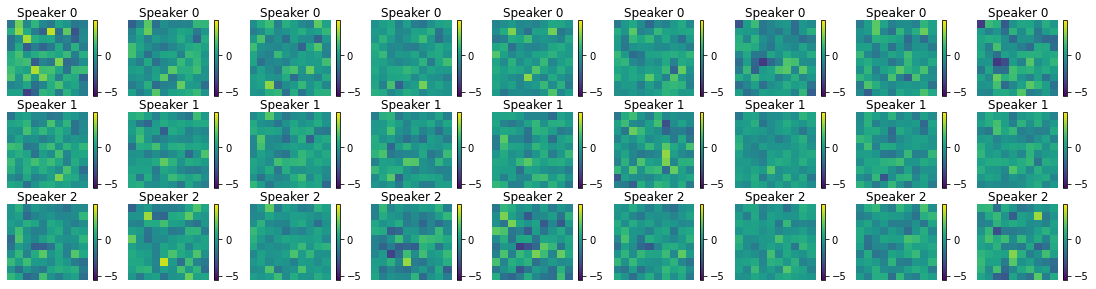

1:


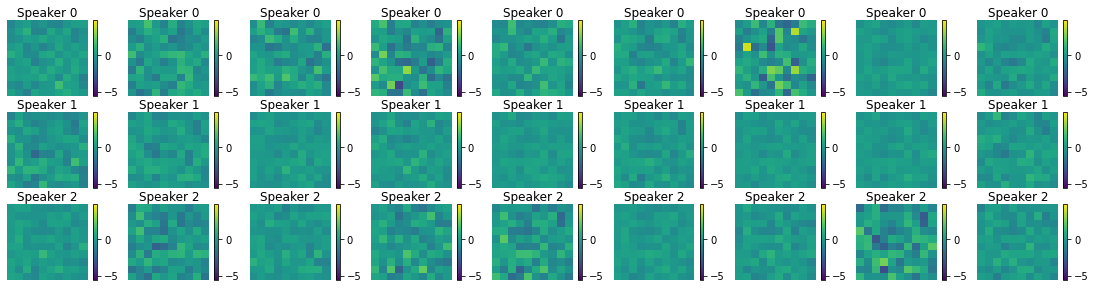

2:


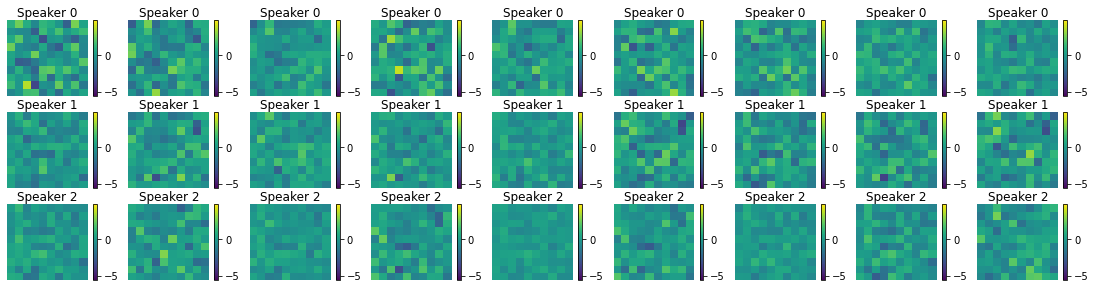

3:


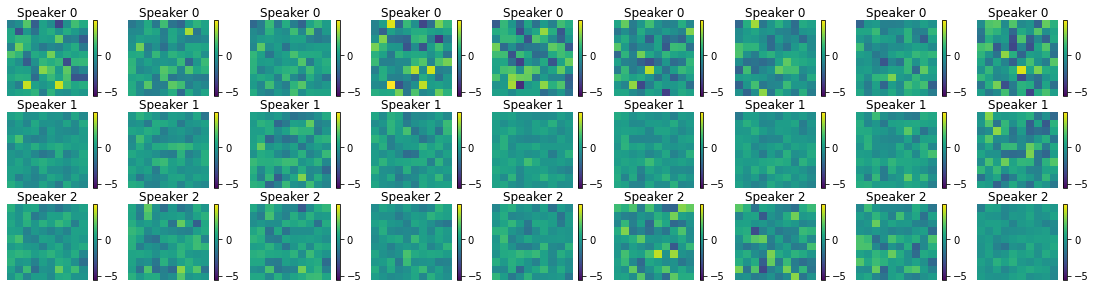

4:


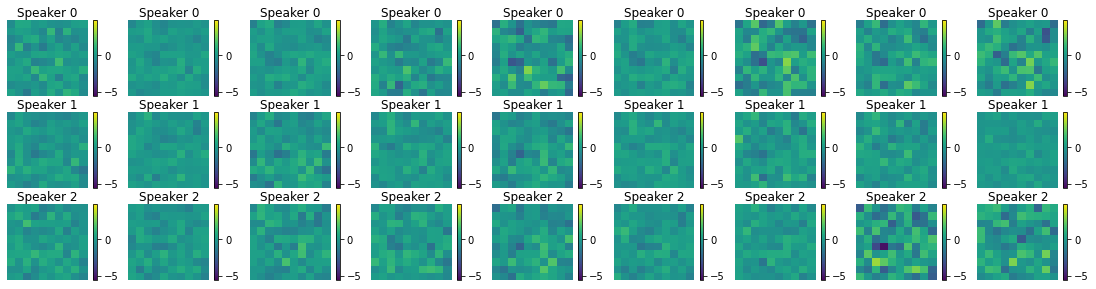

5:


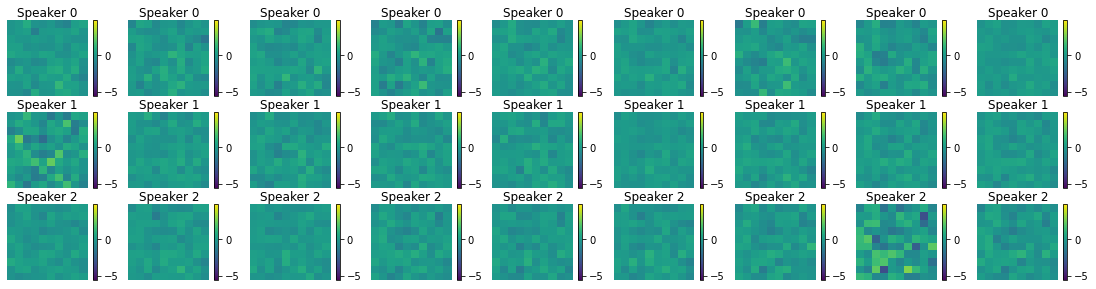

6:


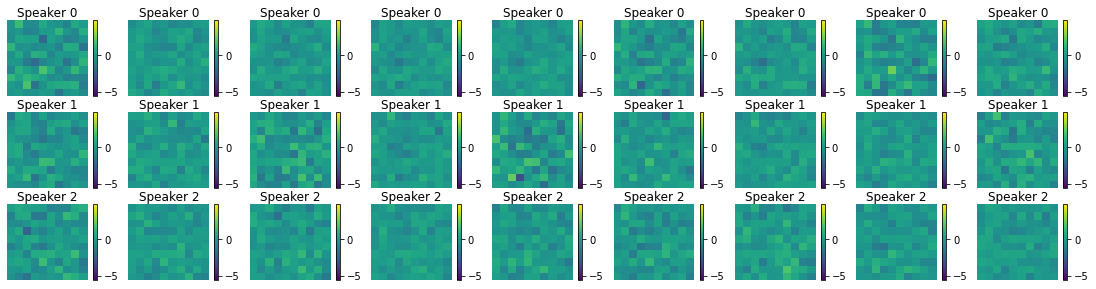

7:


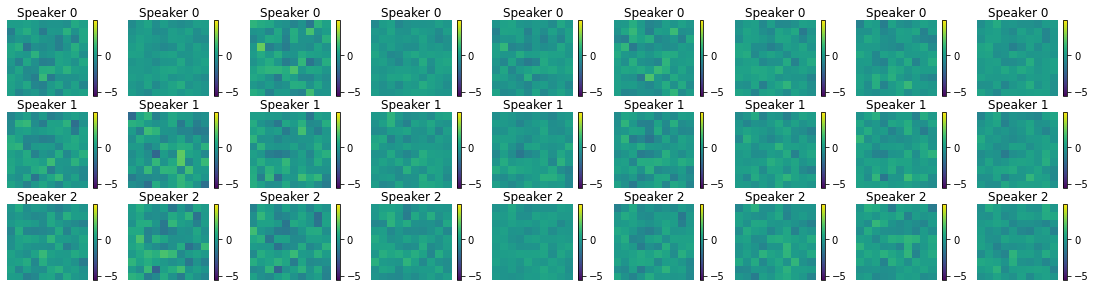

8:


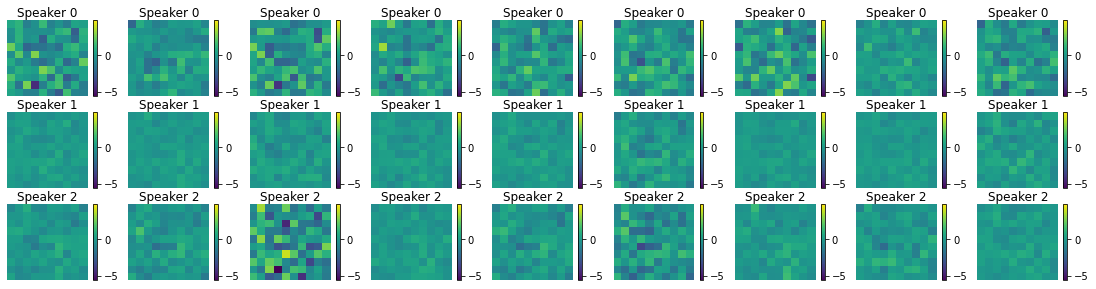

9:


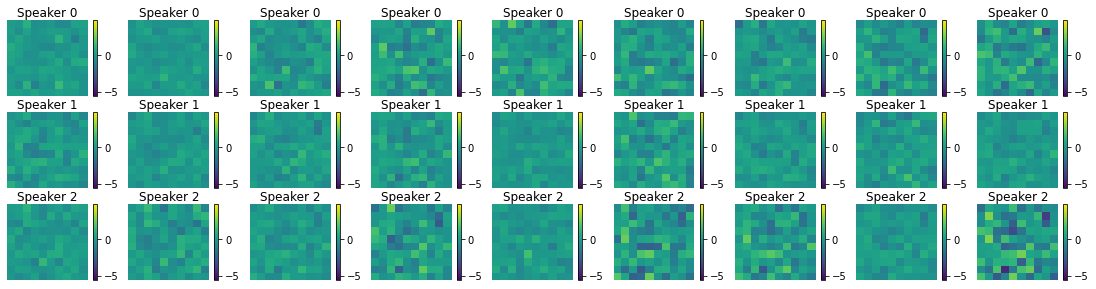

In [ ]:
np.random.seed(69)

X_encoded_digits = np.zeros((10, 3, 9, 100))

for digit in range(10):
    
    for speaker in range(3):

        digit_pos = np.where(((y_digits_train == digit)&(y_speakers_train == speaker)).reshape(-1))[0]
        random_pos = np.random.choice(digit_pos, size=9, replace=False)

        X_encoded_digits[digit, speaker] = X_train_encoded[random_pos, :training_parameters['LATENT_DIM']]
    
        print(f'{digit}: {random_pos}')

X_encoded_digits = X_encoded_digits.reshape(10, 27, 100)

vmin = np.min(X_encoded_digits, axis=(0,1,2))
vmax = np.max(X_encoded_digits, axis=(0,1,2))
cmap = plt.get_cmap('viridis')

for digit in range(10):

    print(f'{digit}:')
    
    plt.figure(figsize=(19.2, 4.8))
    for i in range(27):
        
        plt.subplot(3,9,1+i)
        plt.pcolor(X_encoded_digits[digit][i].reshape(10, 10), cmap=cmap, vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title(f'Speaker {i//9}', pad=0)
        plt.axis('off')
    
    # plt.savefig(os.path.join(root_path, 'results', f'encoded_examples_{digit}.png'))
    plt.show()
    print('=====================================')

# Load models and parameters

## Load preprocessing and training parameters

In [ ]:
MODEL_FOLDER = 'models/autoencoder_mfcc_fc_1_fc_2_ld20_ep1000/'

In [ ]:
training_parameters = utils.load_object(os.path.join(root_path, MODEL_FOLDER, 'training_parameters.pkl'))

librosa_params, input_shape, sr = model_training.load_librosa_params(training_parameters['FEATURES_LIST'])

pprint.pprint(training_parameters)
pprint.pprint(librosa_params)
print(input_shape)

{'BATCH_SIZE': 64,
 'BETA': 0.005,
 'DECAY': 0,
 'DECODER_OUTPUT': 'linear',
 'DECODER_TYPE': 'fc_2',
 'ENCODER_OUTPUT': 'linear',
 'ENCODER_TYPE': 'fc_1',
 'FEATURES_LIST': ['mfcc'],
 'IS_VARIATIONAL': False,
 'LATENT_DIM': 20,
 'LEARNING_RATE': 0.0001,
 'LOSS_TYPE': 'mse_full',
 'NORMALIZE_TYPE': 'avg_std_fband_split',
 'N_EPOCHS': 1000,
 'SAVE_TO': 'models/autoencoder_mfcc_fc_1_fc_2_ld20_ep1000/',
 'USE_CUSTOM_LOSS': True}
{'hop_length': 40,
 'n_fft': 128,
 'n_mels': 64,
 'n_mfcc': 20,
 'sigma_noise': 0,
 'win_length': 120,
 'window': 'hann'}
(20, 201)


In [ ]:
custom_objects = {
    'CustomVariationalLayer': utils.CustomVariationalLayer(beta=training_parameters['BETA']),
    'leaky_relu': tf.nn.leaky_relu
}

#load autoencoder
loaded_autoencoder = utils.load_model(os.path.join(root_path, MODEL_FOLDER, 'autoencoder'), custom_objects)

#load encoder
loaded_encoder = utils.load_model(os.path.join(root_path, MODEL_FOLDER, 'encoder'), custom_objects)

#load decoder
loaded_decoder = utils.load_model(os.path.join(root_path, MODEL_FOLDER, 'decoder'), custom_objects)

Model loaded from /content/drive/My Drive/workspace/internship_virgile_aniti/autoencoder_spoken_mnist/models/autoencoder_mfcc_fc_1_fc_2_ld20_ep1000/autoencoder/ with:
 - model's name: full_auto_encoder 
 - input shape: (None, 4020) 
 - output shape: (None, 4020)
 - last modified: 2020-11-27 09:47:07
Model loaded from /content/drive/My Drive/workspace/internship_virgile_aniti/autoencoder_spoken_mnist/models/autoencoder_mfcc_fc_1_fc_2_ld20_ep1000/encoder/ with:
 - model's name: encoder_fc_1 
 - input shape: (None, 4020) 
 - output shape: (None, 20)
 - last modified: 2020-11-27 09:47:08
Model loaded from /content/drive/My Drive/workspace/internship_virgile_aniti/autoencoder_spoken_mnist/models/autoencoder_mfcc_fc_1_fc_2_ld20_ep1000/decoder/ with:
 - model's name: decoder_fc_2 
 - input shape: (None, 20) 
 - output shape: (None, 4020)
 - last modified: 2020-11-27 09:47:08


In [ ]:
X, dimensions, y_digits, y_speakers, train_index = model_training.load_data(training_parameters['FEATURES_LIST'])
X_train = X[train_index]
y_digits_train = y_digits[train_index]
y_speakers_train = y_speakers[train_index]

X_train_norm, norm_params = model_training.normalize(X_train, training_parameters['NORMALIZE_TYPE'], input_shape)
X_train_from_normalized = model_training.inv_normalize(X_train_norm, training_parameters['NORMALIZE_TYPE'], norm_params, input_shape)

X_train_encoded = loaded_encoder.predict(X_train_norm, batch_size=X_train_norm.shape[0]//10)

X_train_decoded_norm = loaded_decoder.predict(X_train_encoded[:, :training_parameters['LATENT_DIM']], batch_size=X_train_encoded.shape[0]//10)

X_train_decoded = model_training.inv_normalize(X_train_decoded_norm, training_parameters['NORMALIZE_TYPE'], norm_params, input_shape)

# y_pred_input_train = np.argmax(loaded_classifier.predict(X_train.reshape(X_train.shape[0], *input_shape, 1), batch_size=X_train.shape[0]//10), axis=1)
# y_pred_normalized = np.argmax(loaded_classifier.predict(X_train_from_normalized.reshape(X_train_from_normalized.shape[0], *input_shape, 1), batch_size=X_train_from_normalized.shape[0]//10), axis=1)
# y_pred_decoded_train = np.argmax(loaded_classifier.predict(X_train_decoded.reshape(X_train.shape[0], *input_shape, 1), batch_size=X_train.shape[0]//10), axis=1)

# Reconstruction on training set

## Wave reconstruction

### Visualization of an example

In [ ]:
i = 333

dim = input_shape[0]*input_shape[1]

digit = y_digits_train[i]
speaker = y_speakers_train[i]

input = X_train[i, :dim].reshape(input_shape)
input_from_normalized = X_train_from_normalized[i, :dim].reshape(input_shape)
decoded = X_train_decoded[i, :dim].reshape(input_shape)

x = X_train_norm[i, :dim].reshape(input_shape)
y = X_train_decoded_norm[i, :dim].reshape(input_shape)

# print(f'digit: {digit}, latent_code: {X_train_encoded[i]} (rescaled: {X_rescaled[i]}).')

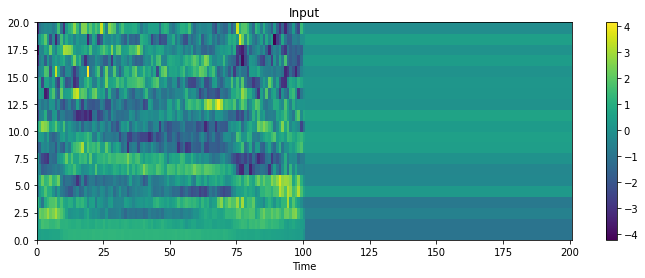

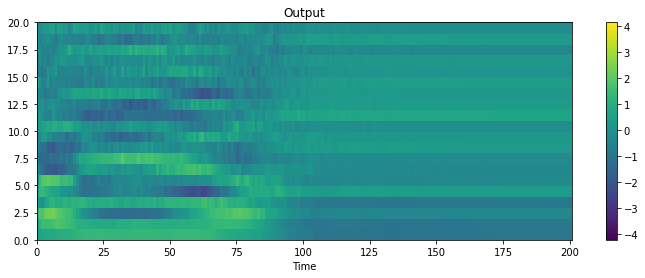

In [ ]:
vmin = min(np.min(x, axis=(0,1)), np.min(y, axis=(0,1)))
vmax = max(np.max(x, axis=(0,1)), np.max(y, axis=(0,1)))
cmap = plt.get_cmap('viridis')

plt.figure(figsize=(12, 4))
plt.pcolor(x, cmap=cmap, vmin=vmin, vmax=vmax)
plt.xlabel('Time')
plt.title('Input')
plt.colorbar()
plt.savefig(os.path.join(root_path, 'results', 'normalized_input.png'))
plt.show()

plt.figure(figsize=(12, 4))
plt.pcolor(y, cmap=cmap, vmin=vmin, vmax=vmax)
plt.xlabel('Time')
plt.title('Output')
plt.colorbar()
plt.savefig(os.path.join(root_path, 'results', 'normalized_output.png'))
plt.show()

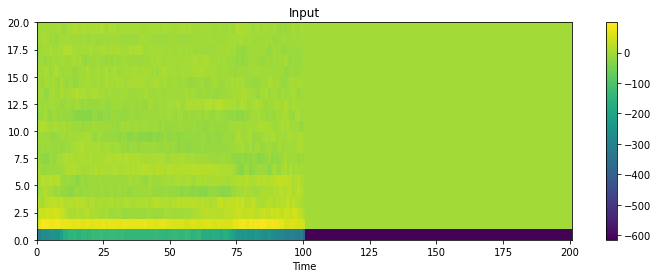

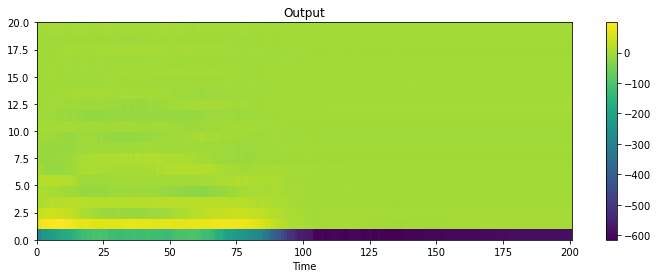

In [ ]:
vmin = min(np.min(input, axis=(0,1)), np.min(decoded, axis=(0,1)))
vmax = max(np.max(input, axis=(0,1)), np.max(decoded, axis=(0,1)))
cmap = plt.get_cmap('viridis')

plt.figure(figsize=(12, 4))
plt.pcolor(input, cmap=cmap, vmin=vmin, vmax=vmax)
plt.xlabel('Time')
plt.title('Input')
plt.colorbar()
plt.savefig(os.path.join(root_path, 'results', 'input.png'))
plt.show()

plt.figure(figsize=(12, 4))
plt.pcolor(decoded, cmap=cmap, vmin=vmin, vmax=vmax)
plt.xlabel('Time')
plt.title('Output')
plt.colorbar()
plt.savefig(os.path.join(root_path, 'results', 'decoded.png'))
plt.show()

In [ ]:
if training_parameters['FEATURES_LIST'] == ['mfcc']:

    wav_from_input = librosa.feature.inverse.mfcc_to_audio(
        input, 
        n_mels=librosa_params['n_mels'], 
        dct_type=2, 
        norm="ortho", 
        ref=1.0, 
        lifter=0,
        sr=sr,
        n_fft=librosa_params['n_fft'],
        hop_length=librosa_params['hop_length'],
        win_length=librosa_params['win_length'],
        window='hann'
    )

    wav_from_input_from_normalized = librosa.feature.inverse.mfcc_to_audio(
        input_from_normalized, 
        n_mels=librosa_params['n_mels'], 
        dct_type=2, 
        norm="ortho", 
        ref=1.0, 
        lifter=0,
        sr=sr,
        n_fft=librosa_params['n_fft'],
        hop_length=librosa_params['hop_length'],
        win_length=librosa_params['win_length'],
        window='hann'
    )

    wav_from_decoded = librosa.feature.inverse.mfcc_to_audio(
        decoded, 
        n_mels=librosa_params['n_mels'], 
        dct_type=2, 
        norm="ortho", 
        ref=1.0, 
        lifter=0,
        sr=sr,
        n_fft=librosa_params['n_fft'],
        hop_length=librosa_params['hop_length'],
        win_length=librosa_params['win_length'],
        window='hann'
    )

elif training_parameters['FEATURES_LIST'] == ['mel']:

    if librosa_params['mel_in_db']:
        input = librosa.core.db_to_power(input)
        input_from_normalized = librosa.core.db_to_power(input_from_normalized)
        decoded = librosa.core.db_to_power(decoded)

    wav_from_input = librosa.feature.inverse.mel_to_audio(
        input,
        sr=sr,
        n_fft=librosa_params['n_fft'],
        hop_length=librosa_params['hop_length'],
        win_length=librosa_params['win_length'],
        window='hann'
    )

    wav_from_input_from_normalized = librosa.feature.inverse.mel_to_audio(
        input_from_normalized,
        sr=sr,
        n_fft=librosa_params['n_fft'],
        hop_length=librosa_params['hop_length'],
        win_length=librosa_params['win_length'],
        window='hann'
    )

    wav_from_decoded = librosa.feature.inverse.mel_to_audio(
        decoded,
        sr=sr,
        n_fft=librosa_params['n_fft'],
        hop_length=librosa_params['hop_length'],
        win_length=librosa_params['win_length'],
        window='hann'
    )   

wav_ref = np.load(os.path.join(root_path, 'datasets', 'X_wav.npy'))[train_index][i]

# predicted_digit_ref = np.argmax(loaded_classifier.predict(input.reshape(1, *input.shape, 1), batch_size=1))
# predicted_digit_normalized = np.argmax(loaded_classifier.predict(input_from_normalized.reshape(1, *input.shape, 1), batch_size=1))
# predicted_digit_decoded = np.argmax(loaded_classifier.predict(decoded.reshape(1, *decoded.shape, 1), batch_size=1))

## Presentation (2)

Initial wave
Digit: 9


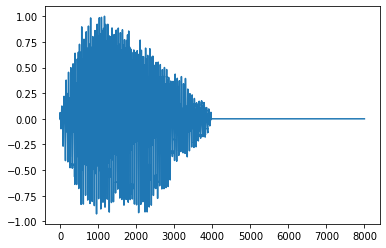

In [ ]:
print('Initial wave')
print('======================================')
print('Digit: {}'.format(digit))
# print('Predicted digit: {}'.format(predicted_digit_ref))
plt.plot(wav_ref)
plt.show()

Audio(wav_ref, rate=sr)

Wave from input (librosa+librosa_back)


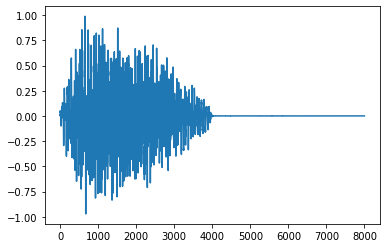

In [ ]:
print('Wave from input (librosa+librosa_back)')
print('======================================')

plt.plot(wav_from_input)
plt.show()

Audio(wav_from_input, rate=sr)

Wave from decoded (librosa+normalization+autoencoder+denormalization+librosa_back)


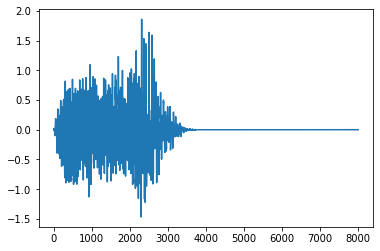

In [ ]:
print('Wave from decoded (librosa+normalization+autoencoder+denormalization+librosa_back)')
# print('Predicted digit: {}'.format(predicted_digit_decoded))

plt.plot(wav_from_decoded)
plt.show()

Audio(wav_from_decoded, rate=sr)